In [3]:
import numpy as np
import pandas as pd

import torch
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit, cross_val_score

import brevitas.nn as nn

from config import *
from classic_models import *
from data_preprocessing import *
from feature_extraction import *
from helpers import *

from torch.utils.data import DataLoader
from tslearn.preprocessing import TimeSeriesScalerMinMax

import warnings
warnings.filterwarnings("ignore")

['dab1_guiyong.json', 'dab1_john.json', 'dab1_kelvin.json', 'dab1_xiaoxue.json', 'dab2_guiyong.json', 'dab2_john.json', 'dab2_kelvin.json', 'dab2_xiaoxue.json', 'dab2_yujie.json', 'elbowkick1_guiyong.json', 'elbowkick1_john.json', 'elbowkick1_kelvin.json', 'elbowkick1_xiaoxue.json', 'elbowkick2_guiyong.json', 'elbowkick2_john.json', 'elbowkick2_kelvin.json', 'elbowkick2_xiaoxue.json', 'elbowkick2_yujie.json', 'gun1_guiyong.json', 'gun1_john.json', 'gun1_kelvin.json', 'gun1_xiaoxue.json', 'gun2_guiyong.json', 'gun2_john.json', 'gun2_kelvin.json', 'gun2_xiaoxue.json', 'gun2_yujie.json', 'hair1_guiyong.json', 'hair1_john.json', 'hair1_kelvin.json', 'hair1_xiaoxue.json', 'hair2_guiyong.json', 'hair2_john.json', 'hair2_kelvin.json', 'hair2_xiaoxue.json', 'hair2_yujie.json', 'listen1_guiyong.json', 'listen1_john.json', 'listen1_kelvin.json', 'listen1_xiaoxue.json', 'listen2_guiyong.json', 'listen2_john.json', 'listen2_kelvin.json', 'listen2_xiaoxue.json', 'listen2_yujie.json', 'pointhigh1_gu

In [4]:
from sklearn import preprocessing
df_train = pd.read_csv('out_5_train.csv')
# df_train = df_train.iloc[:, list(range(21)) + [-1]]
df_test = pd.read_csv('out_5_test.csv')
# df_test = df_test.iloc[:, list(range(21)) + [-1]]
df_train['tag'] = df_train['tag'].apply(lambda x: x-1)
df_test['tag'] = df_test['tag'].apply(lambda x: x-1)

df_train.head()

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.595618,0.823941,0.415132,0.592886,-0.000262,0.126108,0.222181,0.0,1.0,0.0,...,0.555123,-0.000178,0.114960,0.129377,0.0,2.0,0.325,0.205184,-0.346658,0.0
1,0.595657,0.825499,0.415132,0.592886,0.000656,0.126178,0.222181,0.0,1.0,0.0,...,0.555123,0.000730,0.114954,0.129377,0.0,2.0,0.275,0.205113,-0.343758,0.0
2,0.595753,0.825499,0.415132,0.592886,-0.000072,0.126336,0.222181,0.0,1.0,0.0,...,0.556420,0.000049,0.114928,0.129377,0.0,2.0,0.325,0.204948,-0.336518,0.0
3,0.595612,0.825499,0.415132,0.592886,-0.000370,0.126122,0.222181,0.0,1.0,0.0,...,0.557717,0.000178,0.114924,0.129377,0.0,2.0,0.350,0.204882,-0.333833,0.0
4,0.593477,0.825499,0.415132,0.592886,-0.002925,0.123803,0.214461,0.0,2.0,0.0,...,0.557717,0.000049,0.114924,0.129377,0.0,2.0,0.350,0.204882,-0.333833,0.0


In [5]:
print(window_size, overlap)

40 39


In [6]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        if isinstance(df, pd.DataFrame):
            df_np = df.to_numpy()
        self.X = df_np[:,:-1]
        self.y = df_np[:,-1]

    def __getitem__(self, idx):
        # get item by index
        return self.X[idx], self.y[idx]

    def __len__(self):
        # returns length of data
        return len(self.X)

In [7]:
dataset = FeatureDataset(df_train)
D_in = 72 # df.shape[1]-1
D_out = 8 # len(dances)
print(D_in, D_out)

72 8


In [8]:
class MLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True)#, weight_bit_width=4)
        self.linear2 = nn.QuantLinear(d_hidden, d_hidden, bias=True)#, weight_bit_width=4)
        self.linear3 = nn.QuantLinear(d_hidden, d_out, bias=False)#, weight_bit_width=4)
        
        self.relu = torch.nn.ReL(p=0.1)

    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.linear1(X.float())
        X = self.linear2(X)
        X = self.linear3(X)
        return torch.nn.functional.sigmoid(X)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [9]:
class MLP(torch.nn.Module):
    def __init__(self, d_in, d_hidden, d_out):
        super(MLP, self).__init__()
        self.d_in = d_in

        self.linear1 = nn.QuantLinear(d_in, d_hidden, bias=True)
        self.linear2 = nn.QuantLinear(d_hidden, d_hidden//4, bias=True)
        self.linear3 = nn.QuantLinear(d_hidden//4, d_hidden//4, bias=True)
        self.linear4 = nn.QuantLinear(d_hidden//4, d_hidden//8, bias=True)
        self.linear5 = nn.QuantLinear(d_hidden//8, d_out, bias=False)

        self.dropout = torch.nn.Dropout(p=0.65)
        self.relu = torch.nn.ReLU()
        
    def forward(self, X):
        X = X.view(-1, self.d_in)
        X = self.relu(self.linear1(X.float()))
        X = self.dropout(X)
        X = self.relu(self.linear2(X))
        X = self.dropout(X)
        X = self.relu(self.linear3(X))
        X = self.dropout(X)
        X = self.relu(self.linear4(X))
        X = self.dropout(X)
        X = self.linear5(X)
        return torch.nn.functional.log_softmax(X, dim=1)
    
    def load(self, model_path):
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, X):
        outputs = self(X.float())
        _, predicted = torch.max(outputs, 1)
        return predicted

In [10]:
def train_val_model(model, criterion, optimizer, X, y, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    tscv = TimeSeriesSplit(n_splits=15, max_train_size=1000)
    kf = KFold(n_splits=50)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    confusion_matrix = torch.zeros(8, 8)

    for i in range(1,num_epochs+1):
        print('Epoch {}/{}'.format(i, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
        # for fold, (train_index, test_index) in enumerate(tscv.split(X_train, y_train)):
        for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
#             if len(train_index) > 500:
#                 train_index = train_index[len(train_index)-500:]
            ### Dividing data into folds
            # print(train_index, test_index, len(X_train))
            x_train_fold = X_train[train_index]
            x_test_fold = X_train[test_index]
            y_train_fold = y_train[train_index]
            y_test_fold = y_train[test_index]

            print('Train Index Length:', len(train_index), end='\t\t')
            print('Test Index Length:', len(test_index), end='\n\n')

            train = torch.utils.data.TensorDataset(torch.tensor(x_train_fold), torch.tensor(y_train_fold))
            test = torch.utils.data.TensorDataset(torch.tensor(x_test_fold), torch.tensor(y_test_fold))
            train_loader = torch.utils.data.DataLoader(train, batch_size = 50, shuffle = False)
            test_loader = torch.utils.data.DataLoader(test, batch_size = 50, shuffle = False)

            running_loss = 0.0
            running_corrects = 0
            for batch_index, (x_batch, y_batch) in enumerate(train_loader):
                optimizer.zero_grad()
                y_pred = model(x_batch)
                _, preds = torch.max(y_pred, 1)
                for t, p in zip(y_batch.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
                # print(y_pred.shape, y_batch.view(-1, 1).shape)
                single_loss = criterion(y_pred, y_batch.long())
                single_loss.backward()
                optimizer.step()
                
                running_loss += single_loss.item() * x_batch.size(0)
                running_corrects += torch.sum(preds == y_batch.data)
            print('Fold No. {}/{}\tEpoch {}/{}\t'.format(fold + 1 , kf.get_n_splits(X_train), i, num_epochs), end='')
            print(f'loss: {single_loss.item():10.8f}')
            
            nsamples = len(train_index)
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.2f}%'.format(
                    phase, epoch_loss, 100 * epoch_acc)
            )
            print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.2f}%'.format(100 * best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return model, losses, accuracies

In [744]:
model = MLP(D_in, 70, D_out)
# model = MultiHead4MLP(D_in, D_out)
# Explore the model
for parameter in model.parameters():
    print(parameter.shape)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

torch.Size([70, 72])
torch.Size([70])
torch.Size([17, 70])
torch.Size([17])
torch.Size([17, 17])
torch.Size([17])
torch.Size([8, 17])
torch.Size([8])
torch.Size([8, 8])
Total number of parameters = 6831


In [747]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.4)
criterion = torch.nn.NLLLoss()
NUM_EPOCHS = 10

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataset.X, dataset.y, num_epochs=NUM_EPOCHS)

Epoch 1/10
----------
Train Index Length: 775		Test Index Length: 16

Fold No. 1/50	Epoch 1/10	loss: 1.81977499
val Loss: 1.9331 Acc: 26.97%

Train Index Length: 775		Test Index Length: 16

Fold No. 2/50	Epoch 1/10	loss: 1.81197011
val Loss: 1.9283 Acc: 27.48%

Train Index Length: 775		Test Index Length: 16

Fold No. 3/50	Epoch 1/10	loss: 1.80621815
val Loss: 1.9258 Acc: 27.35%

Train Index Length: 775		Test Index Length: 16

Fold No. 4/50	Epoch 1/10	loss: 1.80384159
val Loss: 1.9266 Acc: 27.35%

Train Index Length: 775		Test Index Length: 16

Fold No. 5/50	Epoch 1/10	loss: 1.79919541
val Loss: 1.9208 Acc: 27.74%

Train Index Length: 775		Test Index Length: 16

Fold No. 6/50	Epoch 1/10	loss: 1.79428172
val Loss: 1.9202 Acc: 27.48%

Train Index Length: 775		Test Index Length: 16

Fold No. 7/50	Epoch 1/10	loss: 1.79001880
val Loss: 1.9181 Acc: 27.87%

Train Index Length: 775		Test Index Length: 16

Fold No. 8/50	Epoch 1/10	loss: 1.78638744
val Loss: 1.9133 Acc: 28.13%

Train Index Length

Fold No. 19/50	Epoch 2/10	loss: 1.56127012
val Loss: 1.7344 Acc: 35.10%

Train Index Length: 775		Test Index Length: 16

Fold No. 20/50	Epoch 2/10	loss: 1.55729032
val Loss: 1.7225 Acc: 35.35%

Train Index Length: 775		Test Index Length: 16

Fold No. 21/50	Epoch 2/10	loss: 1.55306745
val Loss: 1.7250 Acc: 35.35%

Train Index Length: 775		Test Index Length: 16

Fold No. 22/50	Epoch 2/10	loss: 1.55465865
val Loss: 1.7267 Acc: 34.97%

Train Index Length: 775		Test Index Length: 16

Fold No. 23/50	Epoch 2/10	loss: 1.55036747
val Loss: 1.7166 Acc: 34.84%

Train Index Length: 775		Test Index Length: 16

Fold No. 24/50	Epoch 2/10	loss: 1.54867733
val Loss: 1.7087 Acc: 35.48%

Train Index Length: 775		Test Index Length: 16

Fold No. 25/50	Epoch 2/10	loss: 1.54667866
val Loss: 1.7111 Acc: 35.35%

Train Index Length: 775		Test Index Length: 16

Fold No. 26/50	Epoch 2/10	loss: 1.54330325
val Loss: 1.7090 Acc: 35.10%

Train Index Length: 775		Test Index Length: 16

Fold No. 27/50	Epoch 2/10	loss: 

Fold No. 37/50	Epoch 3/10	loss: 1.45483947
val Loss: 1.5378 Acc: 41.42%

Train Index Length: 775		Test Index Length: 16

Fold No. 38/50	Epoch 3/10	loss: 1.45239747
val Loss: 1.5381 Acc: 41.29%

Train Index Length: 775		Test Index Length: 16

Fold No. 39/50	Epoch 3/10	loss: 1.45131528
val Loss: 1.5335 Acc: 41.55%

Train Index Length: 775		Test Index Length: 16

Fold No. 40/50	Epoch 3/10	loss: 1.45062041
val Loss: 1.5276 Acc: 41.81%

Train Index Length: 775		Test Index Length: 16

Fold No. 41/50	Epoch 3/10	loss: 1.44588852
val Loss: 1.5328 Acc: 41.42%

Train Index Length: 776		Test Index Length: 15

Fold No. 42/50	Epoch 3/10	loss: 1.41781425
val Loss: 1.5243 Acc: 42.40%

Train Index Length: 776		Test Index Length: 15

Fold No. 43/50	Epoch 3/10	loss: 1.41677642
val Loss: 1.5189 Acc: 43.17%

Train Index Length: 776		Test Index Length: 15

Fold No. 44/50	Epoch 3/10	loss: 1.41339004
val Loss: 1.5199 Acc: 42.40%

Train Index Length: 776		Test Index Length: 15

Fold No. 45/50	Epoch 3/10	loss: 

Fold No. 5/50	Epoch 5/10	loss: 1.34301174
val Loss: 1.3829 Acc: 44.65%

Train Index Length: 775		Test Index Length: 16

Fold No. 6/50	Epoch 5/10	loss: 1.34194398
val Loss: 1.3922 Acc: 44.52%

Train Index Length: 775		Test Index Length: 16

Fold No. 7/50	Epoch 5/10	loss: 1.33975458
val Loss: 1.3930 Acc: 44.52%

Train Index Length: 775		Test Index Length: 16

Fold No. 8/50	Epoch 5/10	loss: 1.33817637
val Loss: 1.3877 Acc: 44.65%

Train Index Length: 775		Test Index Length: 16

Fold No. 9/50	Epoch 5/10	loss: 1.33686972
val Loss: 1.3898 Acc: 44.90%

Train Index Length: 775		Test Index Length: 16

Fold No. 10/50	Epoch 5/10	loss: 1.32974243
val Loss: 1.3853 Acc: 45.29%

Train Index Length: 775		Test Index Length: 16

Fold No. 11/50	Epoch 5/10	loss: 1.32841945
val Loss: 1.3842 Acc: 45.03%

Train Index Length: 775		Test Index Length: 16

Fold No. 12/50	Epoch 5/10	loss: 1.32464278
val Loss: 1.3784 Acc: 45.03%

Train Index Length: 775		Test Index Length: 16

Fold No. 13/50	Epoch 5/10	loss: 1.325

KeyboardInterrupt: 

In [728]:
NUM_EPOCHS = 1
overlap = 48
window_size = 50

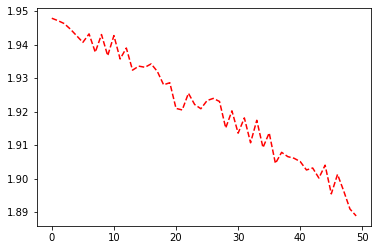

In [729]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [730]:
name = f'MLP_Model_moves_{D_out}_windowsize{window_size}_overlap{overlap}_epoch{NUM_EPOCHS}'
torch.save(model.state_dict(), name)

In [731]:
mlp_model = MLP(D_in, 70, D_out)
mlp_model.load(name)
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in mlp_model.state_dict():
    print(param_tensor, "\t\t", mlp_model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")

with open('weights.txt', 'w') as outfile:
    for var_name in optimizer.state_dict():
        if var_name == 'state':
            for i in range(len(mlp_model.state_dict())):
                print(var_name, "\t", optimizer.state_dict()[var_name][i]['momentum_buffer'].shape)
                # print(var_name, "\t", np.array(optimizer.state_dict()[var_name][i]['momentum_buffer']))
                y = np.array(optimizer.state_dict()[var_name][i]['momentum_buffer'])
                for x in y:
                    x = str(x)
                    x = x.replace('[','{').replace(']','}').replace(' ', ', ').replace('{,', '{').replace(', ,', ',').replace('\n,', ',\n')
                    outfile.write(x)
                # np.savetxt(outfile, np.array(optimizer.state_dict()[var_name][i]['momentum_buffer'])

Model's state_dict:
linear1.weight 		 torch.Size([70, 72])
linear1.bias 		 torch.Size([70])
linear2.weight 		 torch.Size([17, 70])
linear2.bias 		 torch.Size([17])
linear3.weight 		 torch.Size([17, 17])
linear3.bias 		 torch.Size([17])
linear4.weight 		 torch.Size([8, 17])
linear4.bias 		 torch.Size([8])
linear5.weight 		 torch.Size([8, 8])
Optimizer's state_dict:


KeyError: 'momentum_buffer'

In [11]:
mlp_model = MLP(D_in, 70, D_out)
mlp_model.load(name)
mlp_model.eval()

for to_predict in range(D_out):
    df_target = df_test[df_test['tag'] == to_predict]
    df_target = torch.from_numpy(np.array(df_target)[:,:-1])

#     df_random = df_test

#     df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_target)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

NameError: name 'name' is not defined

In [ ]:
import json

dances = ['dab', 'elbowkick', 'gun', 'hair', 'listen', 'pointhigh', 'sidepump', 'wipetable']
# dances = ['gun', 'hair', 'sidepump']
# dances = ['elbowkick', 'pointhigh', 'wipetable']
persons = ['kelvin', 'guiyong', 'xiaoxue', 'john']
beetles = ['1', '2']

test_range = 12
leap = 100
truth, total, skipped = 0,0,0
for i in range(18,18+test_range):
    print("Phase:", i)
    start, end = i * leap, i * leap + leap
    for d in dances:
        print(d)
        df_full = pd.DataFrame()
        collection = [np.array([]) for x in range(16)]
        j = 0
        for p in persons:
            for b in beetles:
                if b == '1':
                    continue
                move_json = 'collected_data/' + d + b + '_' + p + '.json'
                with open(move_json) as f:
                    x = json.load(f)
                x = pd.DataFrame.from_dict(x)[100:400]
                df_target = torch.from_numpy(np.array(feature_extraction(x)))
                output = mlp_model.predict(df_target)
                proba_dict = {}

                for x in output:
                    x = int(x)
                    if x not in proba_dict:
                        proba_dict[x] = 1
                    else:
                        proba_dict[x] += 1
                for k in proba_dict.keys():
                    proba_dict[k] /= len(output)

                print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [ ]:
def feature_extract(df, window_size):
    full_features = np.array([])
    axis = ['accel1', 'accel2', 'accel3', 'gyro1', 'gyro2', 'gyro3']
    titles = np.ravel(np.array([i+'_'+j for i in feature_list for j in axis]))

    # print("Begin Feature Extraction")
    windows = set_sliding_windows(df, 48, window_size)
    # windows = set_windows(df, window_size)

    for window in windows:
        for _,ax in enumerate(window.T):
                full_features = np.append(full_features, add_mean(ax))
                full_features = np.append(full_features, add_max(ax))
                full_features = np.append(full_features, add_min(ax))
                full_features = np.append(full_features, add_median(ax))
                full_features = np.append(full_features, add_gradient(ax))
                full_features = np.append(full_features, add_std(ax))
                full_features = np.append(full_features, add_iqr(ax))
                # full_features = np.append(full_features, add_skew(ax))
                full_features = np.append(full_features, add_zero_crossing_count(ax))
                # full_features = np.append(full_features, add_cwt(ax))
                full_features = np.append(full_features, add_no_peaks(ax))
                full_features = np.append(full_features, add_recurring_dp(ax))
                # full_features = np.append(full_features, add_ratio_v_tsl(ax))
                # full_features = np.append(full_features, add_sum_recurring_dp(ax))
                full_features = np.append(full_features, add_var_coeff(ax))
                full_features = np.append(full_features, add_kurtosis(ax)) 

    full_features = full_features.reshape(
        -1,
        len(feature_list) * 6,
    )   
    full_features_df = pd.DataFrame(full_features)
    full_features_df.columns = titles
    return full_features_df

def feature_extraction(data):
    data = pd.DataFrame.from_dict(data)
    if 'dance' in data:
        del data['dance']

    df = data.apply(pd.to_numeric).interpolate(method='polynomial', order=2)
    col = df.columns
    # X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0)
    df_scaled = df.apply(lambda x: (x - mean(x)) / std(x))
    # df_scaled = df.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
    # min_max_scaler = preprocessing.MinMaxScaler()
    # df_scaled = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=col)
    df.reset_index(drop=True, inplace=True)

    print(df.shape)
    features = feature_extract(df, window_size=50).reset_index(drop=True)
    # print(features.shape)
    return features

In [ ]:
import json
with open("collected_data/dab2_guiyong.json") as f:
    x = json.load(f)
x = pd.DataFrame.from_dict(x)[120:240]
feature_extraction(x)

In [687]:
dataset.df.head(72)

,mean_accel1,mean_accel2,mean_accel3,mean_gyro1,mean_gyro2,mean_gyro3,max_accel1,max_accel2,max_accel3,max_gyro1,...,var_coeff_gyro1,var_coeff_gyro2,var_coeff_gyro3,kurtosis_accel1,kurtosis_accel2,kurtosis_accel3,kurtosis_gyro1,kurtosis_gyro2,kurtosis_gyro3,tag
0,0.619921,0.852686,0.415965,0.644185,0.004212,0.120937,0.139660,0.0,3.0,0.00,...,0.513191,0.009334,0.136847,0.188756,0.0,1.0,0.14,0.275968,-0.960621,0.0
1,0.624279,0.852686,0.416880,0.644185,-0.001367,0.116153,0.135386,0.0,3.0,0.00,...,0.516332,0.009095,0.137426,0.223304,0.0,1.0,0.14,0.267198,-1.087590,0.0
2,0.628567,0.852686,0.416880,0.647176,0.004263,0.117444,0.141651,0.0,3.0,0.00,...,0.531407,0.003719,0.131167,0.201319,0.0,2.0,0.18,0.250598,-0.998598,0.0
3,0.635413,0.852686,0.416880,0.654197,0.003841,0.122414,0.153426,0.0,3.0,0.00,...,0.534548,0.002198,0.127450,0.185302,0.0,2.0,0.18,0.240380,-0.874532,0.0
4,0.642668,0.852686,0.416880,0.666117,0.003439,0.128431,0.157654,0.0,2.0,0.00,...,0.534548,0.000113,0.126936,0.185302,0.0,2.0,0.18,0.238541,-0.847370,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.638731,0.855403,0.433303,0.633242,-0.001171,0.120727,0.165690,0.0,2.0,0.00,...,0.562814,0.004372,0.107036,0.145729,0.0,2.0,0.08,0.188983,-0.345404,0.0
68,0.634350,0.855403,0.433303,0.633242,-0.003033,0.125137,0.181677,0.0,2.0,0.00,...,0.562814,0.002387,0.096728,0.145729,0.0,2.0,0.12,0.168880,-0.719264,0.0
69,0.626859,0.855403,0.417308,0.632799,-0.004421,0.131631,0.203022,0.0,2.0,0.00,...,0.562814,-0.000402,0.093748,0.145729,0.0,2.0,0.12,0.163197,-0.898353,0.0
70,0.617916,0.855403,0.417308,0.614850,-0.004626,0.136993,0.216331,0.0,2.0,0.00,...,0.562814,-0.003920,0.100980,0.145729,0.0,2.0,0.12,0.177072,-0.475365,0.0


In [106]:
D_in

72

## Hierarchical Test

In [ ]:
df_hierarchical = df.copy()
df_hierarchical['tag'] = df_hierarchical['tag'].apply(lambda x: 0 if x <= 7 else 1)

msk = np.random.rand(len(df_hierarchical)) < 0.8
df_train = df_hierarchical[msk]
df_test = df_hierarchical[~msk]

dataset = FeatureDataset(df_train)

In [ ]:
model_hierarchical = MLP(D_in, 50, 2)
optimizer = torch.optim.SGD(model_hierarchical.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()
model, losses, accuracies = train_val_model(model_hierarchical, criterion, optimizer, dataset.X, dataset.y, num_epochs=5)

In [ ]:
torch.save(model.state_dict(), 'MLP_Model_Hierarchical_1')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 2)
mlp_model.load('MLP_Model_Hierarchical_1')
mlp_model.eval()

for to_predict in range(2):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)
    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [ ]:
df_hierarchical_2 = df.copy()
df_hierarchical_2 = df_hierarchical_2[df_hierarchical_2['tag'] >= 8]
df_hierarchical_2 = df_hierarchical_2.apply(lambda x: x-8)
msk = np.random.rand(len(df_hierarchical_2)) < 0.8
df_train = df_hierarchical_2[msk]
df_test = df_hierarchical_2[~msk]

dataset = FeatureDataset(df_train)

model_hierarchical_2 = MLP(D_in, 50, 2)
# optimizer = torch.optim.Adam(model_hierarchical_2.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model_hierarchical_2.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.CrossEntropyLoss()
model, losses, accuracies = train_val_model(model_hierarchical_2, criterion, optimizer, dataset.X, dataset.y, num_epochs=20)

torch.save(model.state_dict(), 'MLP_Model_Hierarchical_2')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 2)
mlp_model.load('MLP_Model_Hierarchical_2')
mlp_model.eval()

for to_predict in range(2):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x) + 8
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [ ]:
df_hierarchical_3 = df.copy()
df_hierarchical_3 = df_hierarchical_3[df_hierarchical_3['tag'] < 8]
msk = np.random.rand(len(df_hierarchical_3)) < 0.8
df_train = df_hierarchical_3[msk]
df_test = df_hierarchical_3[~msk]

dataset = FeatureDataset(df_train)

model_hierarchical_3 = MLP(D_in, 50, 8)
# optimizer = torch.optim.Adam(model_hierarchical_2.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model_hierarchical_3.parameters(), lr=0.01, momentum=0.5)
criterion = torch.nn.NLLLoss()
model, losses, accuracies = train_val_model(model_hierarchical_3, criterion, optimizer, dataset.X, dataset.y, num_epochs=30)

torch.save(model.state_dict(), 'MLP_Model_Hierarchical_3')

In [ ]:
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
mlp_model = MLP(D_in, 50, 8)
mlp_model.load('MLP_Model_Hierarchical_3')
mlp_model.eval()

for to_predict in range(8):
    df_target = df_test[df_test['tag'] == to_predict]

    df_random = df_test

    df_filtered = torch.from_numpy(np.array(pd.merge(df_target, df_random))[:,:-1])
    output = mlp_model.predict(df_filtered)
    # print(output)
    proba_dict = {}

    for x in output:
        x = int(x)
        if x not in proba_dict:
            proba_dict[x] = 1
        else:
            proba_dict[x] += 1
    for k in proba_dict.keys():
        proba_dict[k] /= len(output)

    print(dict(sorted(proba_dict.items(), key=lambda item: -item[1])))

In [5]:
import statistics

lst = [1,1,1,1,2,3]
print(statistics._counts(lst))
print(max([p[0] for p in statistics._counts(lst)]))

[(1, 4)]
1
